In [46]:
import pandas as pd
import pybedtools as pbt
from glob import glob
import pyranges as pr
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [47]:
# Annotation
gtf = pr.read_gtf('../../data/genomes/GRCm38/gencode.vM22.primary_assembly.annotation.gtf', as_df=True)
gtf = gtf.loc[gtf.Feature == 'transcript']

In [48]:
geneAnnot = gtf[['gene_id', 'gene_name']].drop_duplicates()
geneAnnot.rename(columns={'gene_id': 'stable_gene_id'}, inplace=True)
geneAnnot.stable_gene_id = geneAnnot.stable_gene_id.apply(lambda x: x.split('.')[0])
geneAnnot.head()

,stable_gene_id,gene_name
1,ENSMUSG00000102693,4933401J01Rik
4,ENSMUSG00000064842,Gm26206
7,ENSMUSG00000051951,Xkr4
25,ENSMUSG00000102851,Gm18956
28,ENSMUSG00000103377,Gm37180


In [49]:
# Save to
outpath = f'../../results/CharacterizationOfQuantseqGroups/QuantificationOfBinding3PendsMergedReplicates/'
os.makedirs(outpath, exist_ok=True)
srcOut = '../../results/SourceData/raw_saved/'
os.makedirs(srcOut, exist_ok=True)

In [50]:
# Import files
# Crosslink files - merged replicates
BedFilesRaw = glob('../../data/LIN28_220626_results/Crosslinks/mergedXls/*.bed.gz') + glob('../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/*.bed.gz') +\
    glob('../../data/Pabpc1Crosslinks/PABPC1_ESC_DKO*')
BedFilesRaw = [f for f in BedFilesRaw if 'AllSamples_merged.bed.gz' not in f]
BedFilesRaw = [f for f in BedFilesRaw if '_Lj_' not in f]
BedFilesRaw = [f for f in BedFilesRaw if '_Benthyl_' not in f]


# Quantseq data
GeneTpms = pd.read_csv('../../data/MihaDeseq/GeneLevel_TPM_counts.csv', index_col=0)
# Compute mean TPMs across conditions; first I'll map columns to condition
condDict = {
    'KO_2iL': [c for c in GeneTpms.columns if 'KO' in c and '2iL' in c],
    'KO_FCL': [c for c in GeneTpms.columns if 'KO' in c and 'FCL' in c],
    'S200A_2iL': [c for c in GeneTpms.columns if 'S200A' in c and '2iL' in c],
    'S200A_FCL': [c for c in GeneTpms.columns if 'S200A' in c and 'FCL' in c],
    'S200WT_2iL': [c for c in GeneTpms.columns if 'S200WT' in c and '2iL' in c],
    'S200WT_FCL': [c for c in GeneTpms.columns if 'S200WT' in c and 'FCL' in c],
    }
# Compute mean TPMs for eacgh column set
dfMeanTpms = pd.DataFrame()
for cond, cols in condDict.items():
    dfMeanTpms[cond] = GeneTpms[cols].mean(axis=1)
GeneTpms = dfMeanTpms
# Save as source data file
GeneTpms.to_csv(f'{srcOut}/Gene-Level-TPM_MeanAcrossReplicates.csv', index=True)

# 300 nt upstream of 3P end for slamseq regions
ThreePrimeRegion = pbt.BedTool('../../data/3PrimeEnds/Quantseq/Btquantseq3PEndsExtended300Upstream.bed.gz').sort()

# All quantseq UTRs
minLen = 301
minTPM = 5

RegionsFullDf = pr.read_bed('../../results/GeneGroups_Quantseq/3UtrLoci/QuantseqGroups.bed', as_df=True)
RegionsFullDf['length'] = RegionsFullDf.End - RegionsFullDf.Start
RegionsFullDf = RegionsFullDf.loc[RegionsFullDf.length >= minLen]
RegionsFull = pbt.BedTool.from_dataframe(RegionsFullDf).sort()

# Sample anntation
SampleAnnot = pd.read_csv('../../data/general/SampleAnnotation.csv', index_col=0)



In [51]:
BedFilesRaw

['../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged.bed.gz',
 '../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A-WT_ESC_LIF-CHIR_merged.bed.gz',
 '../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A-WT_ESCiLIF_merged.bed.gz',
 '../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/DOX_C1_Crick_merged.bed.gz',
 '../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/DOX_C4_Proteintech_merged.bed.gz',
 '../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/KO_C4_Proteintech_merged.bed.gz',
 '../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/KO_C1_Crick_merged.bed.gz',
 '../../data/Pabpc1Crosslinks/PABPC1_ESC_DKO_nodox_grouped_cdna_mm39.bed.gz',
 '../../data/Pabpc1Crosslinks/PABPC1_ESC_DKO_doxGFPLin28A_grouped_cdna_mm39.bed.gz']

In [52]:
GeneTpms

,KO_2iL,KO_FCL,S200A_2iL,S200A_FCL,S200WT_2iL,S200WT_FCL
stable_gene_id,,,,,,
ENSMUSG00000000001,6.677950,7.112323,5.880970,5.033886,7.122433,1.797935
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,10.692164,8.045459,9.775650,6.133840,13.348023,3.322841
ENSMUSG00000000031,0.093472,0.000000,0.062915,0.569452,0.000000,0.000000
ENSMUSG00000000037,0.144660,0.038239,0.305144,0.137961,0.196149,0.249172
...,...,...,...,...,...,...
ENSMUSG00000118483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000118485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000118486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
cond = set([c.rsplit('_', 1)[0] for c in GeneTpms.columns])

In [54]:
cond

{'KO', 'S200A', 'S200WT'}

In [55]:
SampleAnnot.head()

,Sample,Protein,Condition,Experiment
0,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1.bed.gz,LIN28A,S200A_FCL,FLAG-IP LIN28A
1,LIN28A-WT_ESC_LIF-CHIR-FGF0220626_MM_1.bed.gz,LIN28A,S200WT_FCL,FLAG-IP LIN28A
2,LIN28A-WT_ESC_LIF-CHIR-FGF0220626_MM_2.bed.gz,LIN28A,S200WT_FCL,FLAG-IP LIN28A
3,LIN28A-WT_ESCiLIF-OLD0220626_MM.bed.gz,LIN28A,S200WT_2iL,FLAG-IP LIN28A
4,LIN28A-WT_ESCiLIF0220626_MM_1.bed.gz,LIN28A,S200WT_2iL,FLAG-IP LIN28A


In [56]:
# Number of regions with minlength 301
RegionsFullDf.groupby('Name').count()

,Chromosome,Start,End,Score,Strand,ThickStart,length
Name,,,,,,,
CONTROL,2154,2154,2154,2154,2154,2154,2154
DOWN,959,959,959,959,959,959,959
UP,775,775,775,775,775,775,775


In [57]:
GeneTpms.head()

,KO_2iL,KO_FCL,S200A_2iL,S200A_FCL,S200WT_2iL,S200WT_FCL
stable_gene_id,,,,,,
ENSMUSG00000000001,6.677950,7.112323,5.880970,5.033886,7.122433,1.797935
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,10.692164,8.045459,9.775650,6.133840,13.348023,3.322841
ENSMUSG00000000031,0.093472,0.000000,0.062915,0.569452,0.000000,0.000000
ENSMUSG00000000037,0.144660,0.038239,0.305144,0.137961,0.196149,0.249172


In [58]:
RegionsFull.head()

chr1	4843433	4846689	CONTROL	-0.221081262692311	-	ENSMUSG00000033845	3256
 chr1	4966584	4968132	DOWN	-1.70947008676754	+	ENSMUSG00000033813	1548
 chr1	9616843	9617680	DOWN	-1.1207029482573	+	ENSMUSG00000061024	837
 chr1	10094825	10095206	CONTROL	0.359694338201388	-	ENSMUSG00000025917	381
 chr1	10206367	10206993	CONTROL	-0.109735532097311	+	ENSMUSG00000056763	626
 chr1	12929850	12931416	DOWN	-2.00258175677654	+	ENSMUSG00000016918	1566
 chr1	13634921	13636549	CONTROL	0.255102213174919	-	ENSMUSG00000025935	1628
 chr1	14823569	14824465	DOWN	-2.02544522719183	-	ENSMUSG00000025930	896
 chr1	15913303	15914276	DOWN	-0.920995300646371	+	ENSMUSG00000025925	973
 chr1	16712990	16713514	DOWN	-2.03541018996949	-	ENSMUSG00000079658	524
 

In [59]:
BedFilesRaw

['../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged.bed.gz',
 '../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A-WT_ESC_LIF-CHIR_merged.bed.gz',
 '../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A-WT_ESCiLIF_merged.bed.gz',
 '../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/DOX_C1_Crick_merged.bed.gz',
 '../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/DOX_C4_Proteintech_merged.bed.gz',
 '../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/KO_C4_Proteintech_merged.bed.gz',
 '../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/KO_C1_Crick_merged.bed.gz',
 '../../data/Pabpc1Crosslinks/PABPC1_ESC_DKO_nodox_grouped_cdna_mm39.bed.gz',
 '../../data/Pabpc1Crosslinks/PABPC1_ESC_DKO_doxGFPLin28A_grouped_cdna_mm39.bed.gz']

In [60]:
samplenames = [f.split('/')[-1] for f in BedFilesRaw]

In [61]:
samplenames

['LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged.bed.gz',
 'LIN28A-WT_ESC_LIF-CHIR_merged.bed.gz',
 'LIN28A-WT_ESCiLIF_merged.bed.gz',
 'DOX_C1_Crick_merged.bed.gz',
 'DOX_C4_Proteintech_merged.bed.gz',
 'KO_C4_Proteintech_merged.bed.gz',
 'KO_C1_Crick_merged.bed.gz',
 'PABPC1_ESC_DKO_nodox_grouped_cdna_mm39.bed.gz',
 'PABPC1_ESC_DKO_doxGFPLin28A_grouped_cdna_mm39.bed.gz']

In [62]:
# Intersect RegionsFull with raw crosslink files and count crosslinks in each sample within each region
librarysizes = {}
for f in BedFilesRaw:
    print(f)
    sname = f.split('/')[-1]
    # Read bed file into dataframe
    bed = pd.read_csv(f, sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand'])
    libsize = bed['score'].sum()
    librarysizes[sname] = libsize
    bed = pbt.BedTool(f).sort()
    # Stranded true, column 5, operation sum
    RegionsFull = RegionsFull.map(bed, s=True, c=5, o='sum', nonamecheck=True, )

../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged.bed.gz
../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A-WT_ESC_LIF-CHIR_merged.bed.gz
../../data/LIN28_220626_results/Crosslinks/mergedXls/LIN28A-WT_ESCiLIF_merged.bed.gz
../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/DOX_C1_Crick_merged.bed.gz
../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/DOX_C4_Proteintech_merged.bed.gz
../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/KO_C4_Proteintech_merged.bed.gz
../../data/Pabpc1Pabpc4Iclip_2022/Crosslinks/mergedXls/KO_C1_Crick_merged.bed.gz
../../data/Pabpc1Crosslinks/PABPC1_ESC_DKO_nodox_grouped_cdna_mm39.bed.gz
../../data/Pabpc1Crosslinks/PABPC1_ESC_DKO_doxGFPLin28A_grouped_cdna_mm39.bed.gz


In [63]:
RegionsFullDf.columns

Index(['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ThickStart',
       'length'],
      dtype='object')

In [64]:
GeneTpms

,KO_2iL,KO_FCL,S200A_2iL,S200A_FCL,S200WT_2iL,S200WT_FCL
stable_gene_id,,,,,,
ENSMUSG00000000001,6.677950,7.112323,5.880970,5.033886,7.122433,1.797935
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,10.692164,8.045459,9.775650,6.133840,13.348023,3.322841
ENSMUSG00000000031,0.093472,0.000000,0.062915,0.569452,0.000000,0.000000
ENSMUSG00000000037,0.144660,0.038239,0.305144,0.137961,0.196149,0.249172
...,...,...,...,...,...,...
ENSMUSG00000118483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000118485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000118486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [65]:
# Normalise by library size
DfQuant = RegionsFull.to_dataframe(names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'geneID', 'length'] + samplenames)

In [66]:
DfQuant.head()

,chrom,start,end,name,score,strand,geneID,length,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged.bed.gz,LIN28A-WT_ESC_LIF-CHIR_merged.bed.gz,LIN28A-WT_ESCiLIF_merged.bed.gz,DOX_C1_Crick_merged.bed.gz,DOX_C4_Proteintech_merged.bed.gz,KO_C4_Proteintech_merged.bed.gz,KO_C1_Crick_merged.bed.gz,PABPC1_ESC_DKO_nodox_grouped_cdna_mm39.bed.gz,PABPC1_ESC_DKO_doxGFPLin28A_grouped_cdna_mm39.bed.gz
0,chr1,4843433,4846689,CONTROL,-0.221081,-,ENSMUSG00000033845,3256,10,108,172,402,108,106,464,24,22
1,chr1,4966584,4968132,DOWN,-1.709470,+,ENSMUSG00000033813,1548,8,23,110,312,37,53,222,436,222
2,chr1,9616843,9617680,DOWN,-1.120703,+,ENSMUSG00000061024,837,27,97,656,1468,158,167,1526,579,190
3,chr1,10094825,10095206,CONTROL,0.359694,-,ENSMUSG00000025917,381,4,80,82,759,148,107,672,33,42
4,chr1,10206367,10206993,CONTROL,-0.109736,+,ENSMUSG00000056763,626,3,21,110,389,58,32,289,131,133


In [67]:
# # Filter out regions with few crosslink sites
DfQuant.loc[:, samplenames] = DfQuant.loc[:, samplenames].replace('.', 0)
DfQuant.loc[:, samplenames] = DfQuant.loc[:, samplenames].astype(int)
# DfQuant['minXl'] = DfQuant.loc[:, samplenames].min(axis=1)
# DfQuant = DfQuant.loc[DfQuant.minXl >= minXls]

In [68]:
# Filter out regions with low TPM (min TPM 1 in all conditions)
mintpms = GeneTpms.loc[:, [c for c in GeneTpms.columns if c != 'Gene Group']].min(axis=1)
sufficient_expression = mintpms.loc[mintpms >= minTPM].index.tolist()
DfQuant = DfQuant.loc[DfQuant.geneID.isin(sufficient_expression)]

In [69]:
# regions included
DfQuant.groupby('name').count()['chrom']

name
CONTROL    1744
DOWN        586
UP          381
Name: chrom, dtype: int64

In [70]:
condition_dict = dict(zip(SampleAnnot.Sample, SampleAnnot.Condition))
condition_dict

{'LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1.bed.gz': 'S200A_FCL',
 'LIN28A-WT_ESC_LIF-CHIR-FGF0220626_MM_1.bed.gz': 'S200WT_FCL',
 'LIN28A-WT_ESC_LIF-CHIR-FGF0220626_MM_2.bed.gz': 'S200WT_FCL',
 'LIN28A-WT_ESCiLIF-OLD0220626_MM.bed.gz': 'S200WT_2iL',
 'LIN28A-WT_ESCiLIF0220626_MM_1.bed.gz': 'S200WT_2iL',
 'LIN28A-WT_ESCiLIF0220626_MM_2.bed.gz': 'S200WT_2iL',
 'DOX_C1_Crick1.bed.gz': 'S200WT_FCL',
 'DOX_C1_Crick2.bed.gz': 'S200WT_FCL',
 'DOX_C4_Benthyl_1.bed.gz': 'S200WT_FCL',
 'DOX_C4_Benthyl_2.bed.gz': 'S200WT_FCL',
 'DOX_C4_Proteintech_1.bed.gz': 'S200WT_FCL',
 'DOX_C4_Proteintech_2.bed.gz': 'S200WT_FCL',
 'KO_C1_Crick1.bed.gz': 'KO_FCL',
 'KO_C1_Crick2.bed.gz': 'KO_FCL',
 'KO_C4_Benthyl_1.bed.gz': 'KO_FCL',
 'KO_C4_Benthyl_2.bed.gz': 'KO_FCL',
 'KO_C4_Proteintech_1.bed.gz': 'KO_FCL',
 'KO_C4_Proteintech_2.bed.gz': 'KO_FCL',
 'DOX_C1_Crick_merged.bed.gz': 'S200WT_FCL',
 'DOX_C1_Lj_merged.bed.gz': 'S200WT_FCL',
 'DOX_C4_Benthyl_merged.bed.gz': 'S200WT_FCL',
 'DOX_C4_Proteintech_merged

In [71]:
# Normalise counts by library size and by expression
gene_order = DfQuant.geneID.values.tolist()

for sname in samplenames:
    print(sname)
    # Get CPM in each regions
    DfQuant[sname] = DfQuant[sname] * 1000000 / librarysizes[sname]
    # Get condition for sample
    condition = condition_dict[sname]
    print(condition)
    # Get TPM per gene (pandas series)
    tpms = GeneTpms.loc[gene_order, condition]
    # print(tpms.shape)
    # Get CPM per TPM
    # print(DfQuant[sname].head())
    DfQuant[sname] = DfQuant[sname].divide(tpms.values, axis=0)
    # print(DfQuant[sname].head())

LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged.bed.gz
S200A_FCL
LIN28A-WT_ESC_LIF-CHIR_merged.bed.gz
S200WT_FCL
LIN28A-WT_ESCiLIF_merged.bed.gz
S200WT_2iL
DOX_C1_Crick_merged.bed.gz
S200WT_FCL
DOX_C4_Proteintech_merged.bed.gz
S200WT_FCL
KO_C4_Proteintech_merged.bed.gz
KO_FCL
KO_C1_Crick_merged.bed.gz
KO_FCL
PABPC1_ESC_DKO_nodox_grouped_cdna_mm39.bed.gz
KO_2iL
PABPC1_ESC_DKO_doxGFPLin28A_grouped_cdna_mm39.bed.gz
S200WT_2iL


In [72]:
DfQuant

,chrom,start,end,name,score,strand,geneID,length,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merged.bed.gz,LIN28A-WT_ESC_LIF-CHIR_merged.bed.gz,LIN28A-WT_ESCiLIF_merged.bed.gz,DOX_C1_Crick_merged.bed.gz,DOX_C4_Proteintech_merged.bed.gz,KO_C4_Proteintech_merged.bed.gz,KO_C1_Crick_merged.bed.gz,PABPC1_ESC_DKO_nodox_grouped_cdna_mm39.bed.gz,PABPC1_ESC_DKO_doxGFPLin28A_grouped_cdna_mm39.bed.gz
0,chr1,4843433,4846689,CONTROL,-0.221081,-,ENSMUSG00000033845,3256,0.532838,1.831834,0.387024,0.901648,0.565653,0.648047,0.977571,0.129424,0.172704
2,chr1,9616843,9617680,DOWN,-1.120703,+,ENSMUSG00000061024,837,0.761266,1.856365,0.802970,3.715065,0.933712,0.454227,1.430346,2.237512,0.811372
3,chr1,10094825,10095206,CONTROL,0.359694,-,ENSMUSG00000025917,381,0.099035,0.426411,0.062934,0.534969,0.243592,0.281937,0.610194,0.066817,0.112458
4,chr1,10206367,10206993,CONTROL,-0.109736,+,ENSMUSG00000056763,626,0.325204,0.886378,0.302400,2.171192,0.755948,0.258620,0.804895,0.830467,1.275591
6,chr1,13634921,13636549,CONTROL,0.255102,-,ENSMUSG00000025935,1628,3.657026,1.501089,3.023969,3.118190,1.112684,4.041509,11.011952,5.271227,12.433673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3879,chrX,161561409,161562088,DOWN,-1.409979,+,ENSMUSG00000031353,679,0.897302,3.529244,0.514207,4.827993,2.671451,0.935031,1.673766,1.130912,0.765334
3881,chrX,162718438,162719287,CONTROL,-0.102017,-,ENSMUSG00000031370,849,0.000000,0.000000,0.002737,0.002298,0.007156,0.000000,0.001844,0.002227,0.003183
3884,chrX,165173028,165174014,CONTROL,-0.076344,-,ENSMUSG00000040586,986,0.000000,0.702100,0.082149,0.598320,0.481782,0.219628,0.820905,0.278349,0.220460
3886,chrX,165990088,165990499,DOWN,-3.866227,-,ENSMUSG00000049775,411,0.082365,0.906742,0.109732,9.146874,4.355211,0.359975,0.757590,0.255170,0.242161


In [73]:
# Plot boxplots
# Melt df
DfQuantMelt = DfQuant.melt(id_vars=['chrom', 'start', 'end', 'name', 'score', 'strand', 'geneID', 'length'], var_name='Sample', value_name='CPMperTPM')
# Merge with SampleAnnot
DfQuantMelt = DfQuantMelt.merge(SampleAnnot, left_on='Sample', right_on='Sample')

In [74]:
DfQuantMelt.head()

,chrom,start,end,name,score,strand,geneID,length,Sample,CPMperTPM,Protein,Condition,Experiment
0,chr1,4843433,4846689,CONTROL,-0.221081,-,ENSMUSG00000033845,3256,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,0.532838,LIN28A,S200A_FCL,FLAG-IP LIN28A - merged
1,chr1,9616843,9617680,DOWN,-1.120703,+,ENSMUSG00000061024,837,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,0.761266,LIN28A,S200A_FCL,FLAG-IP LIN28A - merged
2,chr1,10094825,10095206,CONTROL,0.359694,-,ENSMUSG00000025917,381,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,0.099035,LIN28A,S200A_FCL,FLAG-IP LIN28A - merged
3,chr1,10206367,10206993,CONTROL,-0.109736,+,ENSMUSG00000056763,626,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,0.325204,LIN28A,S200A_FCL,FLAG-IP LIN28A - merged
4,chr1,13634921,13636549,CONTROL,0.255102,-,ENSMUSG00000025935,1628,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,3.657026,LIN28A,S200A_FCL,FLAG-IP LIN28A - merged


LIN28A
S200WT_2iL
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-sided, P_val:2.730e-02 U_stat=4.799e+05
CONTROL vs. UP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.057e-02 U_stat=3.574e+05
S200A_FCL
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-sided, P_val:8.300e-01 U_stat=5.080e+05
CONTROL vs. UP: Mann-Whitney-Wilcoxon test two-sided, P_val:3.564e-03 U_stat=3.639e+05
S200WT_FCL
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-sided, P_val:3.156e-16 U_stat=6.261e+05
CONTROL vs. UP: Mann-Whitney-Wilcoxon test two-sided, P_val:7.559e-21 U_stat=4.338e+05
PABPC1
KO_2iL
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-sided, P_val:6.280e-01 U_stat=5.178e+05
CONTROL vs. UP: Mann-Whitney-Wilcoxon test two-sided, P_val:3.430e-01 U_stat=3.425e+05
S200WT_2iL
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-sided, P_val:6.427e-01 U_stat=5.045e+05
CONTROL vs. UP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.312e-01 U_stat=3.486e+05
KO_FCL
DOWN vs. CONTROL: Mann-Whitney-Wilcoxon test two-

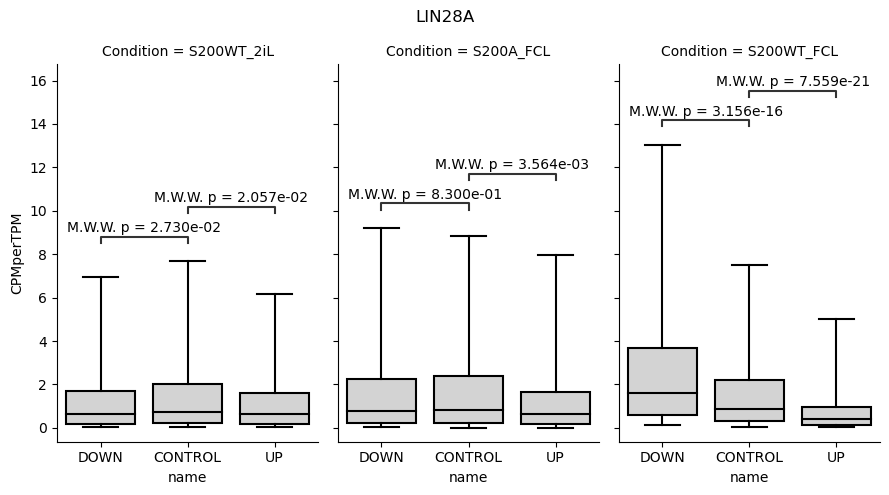

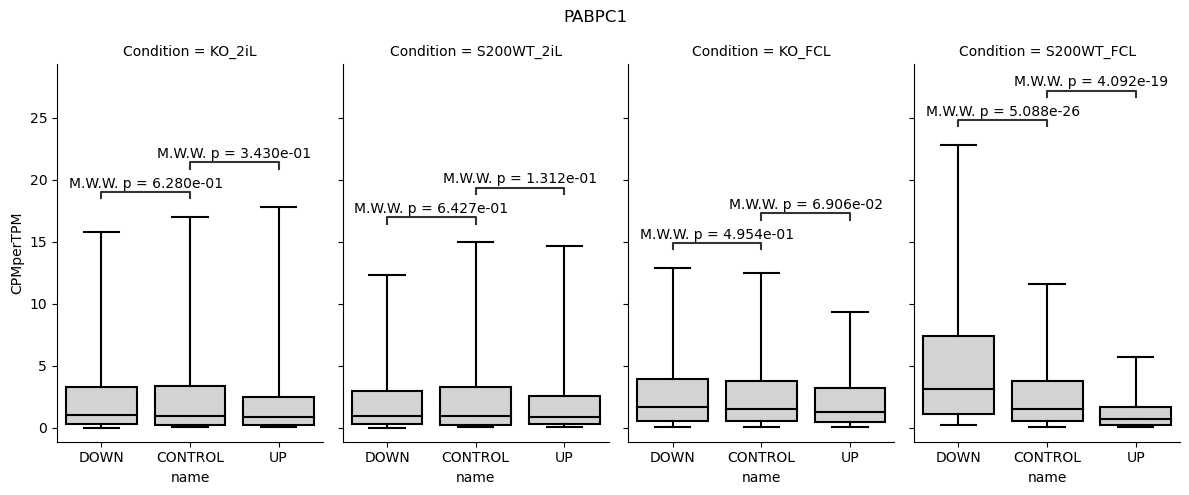

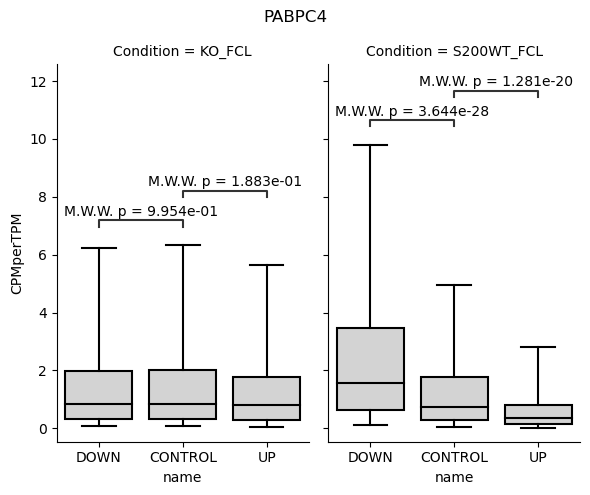

In [75]:
order_dict = {
    'LIN28A': ['S200WT_2iL', 'S200A_FCL', 'S200WT_FCL'],
    'PABPC4': ['KO_FCL', 'S200WT_FCL'],
    'PABPC1':  ['KO_2iL', 'S200WT_2iL', 'KO_FCL', 'S200WT_FCL']
}

for prot, df in DfQuantMelt.groupby('Protein'):
    print(prot)
    # Set boxplot kwargs for seaborn, set edgecolor to black
    PROPS = {
    'boxprops':{'facecolor':'lightgrey', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
    # Make white boxplots of uniform color with black edges
    g = sns.catplot(
        kind='box', data=df, x='name', y='CPMperTPM', col='Condition', showfliers=False, order=['DOWN', 'CONTROL', 'UP'],
        col_order=order_dict[prot], aspect=.6, **PROPS, whis=[5, 95]
        )
    # Add significance
    pairs = [('DOWN', 'CONTROL'), ('CONTROL', 'UP')]
    for idx, ax in g.axes_dict.items():
        print(idx)
        # subset the table otherwise the stats were calculated on the whole dataset
        annot = Annotator(
            ax, pairs,data=df.loc[df['Condition']==idx,:], x='name', y='CPMperTPM' , order=['DOWN', 'CONTROL', 'UP'],
            )
        annot.configure(test='Mann-Whitney', text_format='full', loc='inside')
        _, corrected_results = annot.apply_and_annotate()
    g.figure.suptitle(prot)
    plt.tight_layout()
    g.figure.savefig(f'{outpath}{prot}_CPMperTPM_300ntUpstreamOf3PTermini_minRegLen301nt_boxplots.pdf', bbox_inches='tight')

LIN28A
S200WT_2iL
DOWN vs. Control+UP: Mann-Whitney-Wilcoxon test two-sided, P_val:7.721e-02 U_stat=5.930e+05
S200A_FCL
DOWN vs. Control+UP: Mann-Whitney-Wilcoxon test two-sided, P_val:6.820e-01 U_stat=6.295e+05
S200WT_FCL
DOWN vs. Control+UP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.471e-24 U_stat=7.934e+05
PABPC1
KO_2iL
DOWN vs. Control+UP: Mann-Whitney-Wilcoxon test two-sided, P_val:4.735e-01 U_stat=6.347e+05
S200WT_2iL
DOWN vs. Control+UP: Mann-Whitney-Wilcoxon test two-sided, P_val:8.776e-01 U_stat=6.200e+05
KO_FCL
DOWN vs. Control+UP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.710e-01 U_stat=6.411e+05
S200WT_FCL
DOWN vs. Control+UP: Mann-Whitney-Wilcoxon test two-sided, P_val:6.238e-36 U_stat=8.326e+05
PABPC4
KO_FCL
DOWN vs. Control+UP: Mann-Whitney-Wilcoxon test two-sided, P_val:7.839e-01 U_stat=6.272e+05
S200WT_FCL
DOWN vs. Control+UP: Mann-Whitney-Wilcoxon test two-sided, P_val:8.754e-39 U_stat=8.411e+05


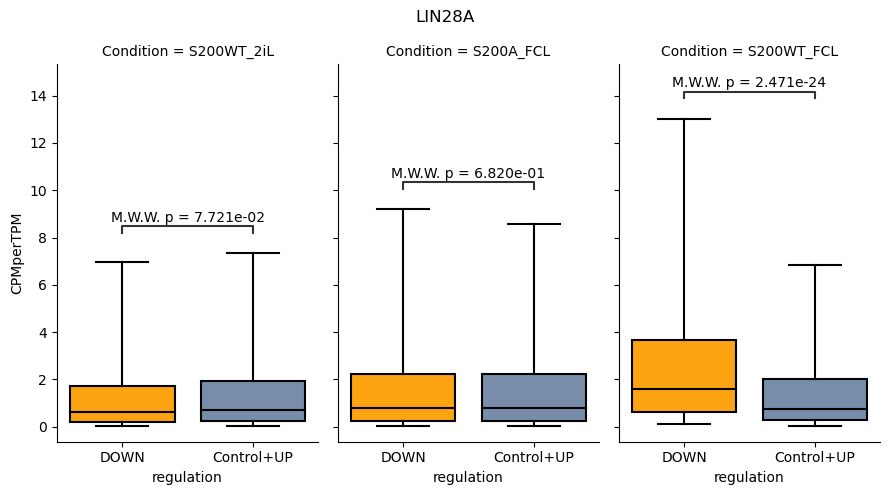

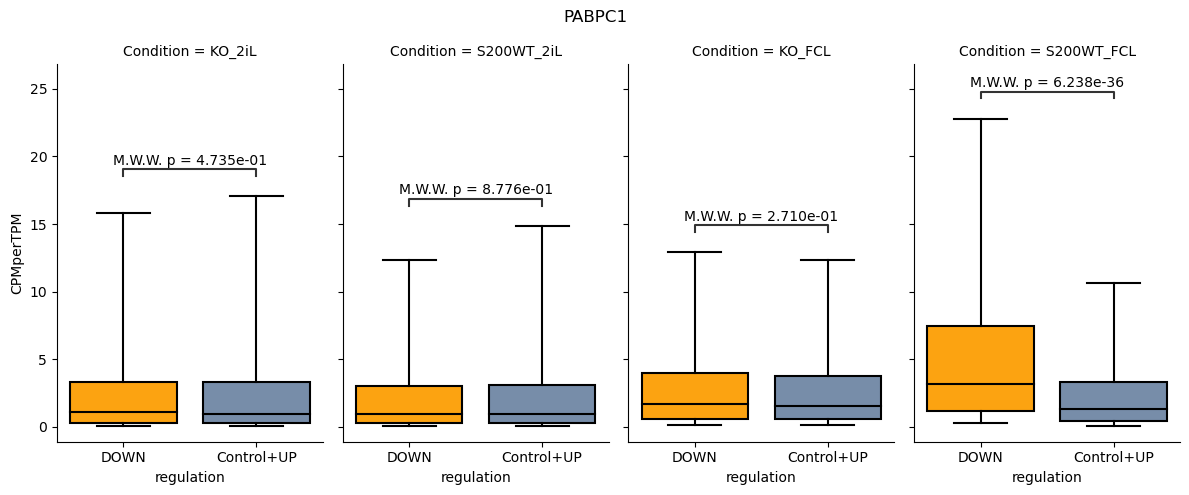

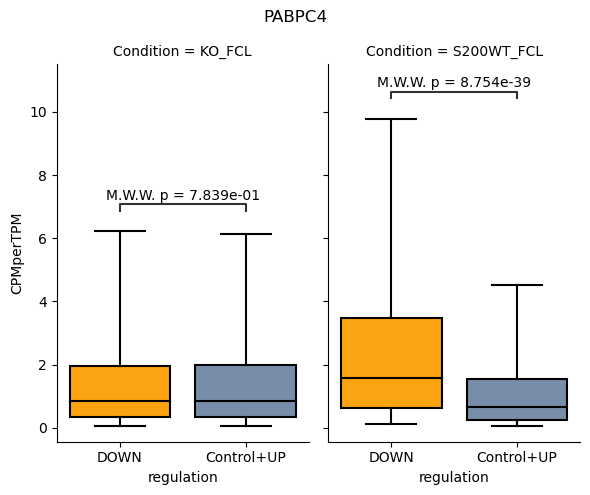

In [76]:
for prot, df in DfQuantMelt.groupby('Protein'):
    print(prot)
    # Set boxplot kwargs for seaborn, set edgecolor to black
    PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
    # Make white boxplots of uniform color with black edges
    df['regulation'] = df.name.map({'DOWN': 'DOWN', 'CONTROL': 'Control+UP', 'UP':'Control+UP'})
    g = sns.catplot(
        kind='box', data=df, x='regulation', y='CPMperTPM', col='Condition', showfliers=False, order=['DOWN', 'Control+UP'],
        col_order=order_dict[prot], aspect=.6, **PROPS, palette=['#fca311', '#778da9'], saturation=1, whis=[5, 95]
        )
    # Add significance
    pairs = [('DOWN', 'Control+UP')]
    for idx, ax in g.axes_dict.items():
        print(idx)
        # subset the table otherwise the stats were calculated on the whole dataset
        annot = Annotator(
            ax, pairs,data=df.loc[df['Condition']==idx,:], x='regulation', y='CPMperTPM' , order=['DOWN', 'Control+UP'],
            )
        annot.configure(test='Mann-Whitney', text_format='full', loc='inside')
        _, corrected_results = annot.apply_and_annotate()
    g.figure.suptitle(prot)
    plt.tight_layout()
    g.figure.savefig(f'{outpath}{prot}_CPMperTPM_300ntUpstreamOf3PTermini_minRegLen301nt_boxplots_2groups.pdf', bbox_inches='tight')

LIN28A
S200A_FCL_Control+UP vs. S200A_FCL_DOWN: Mann-Whitney-Wilcoxon test two-sided, P_val:6.820e-01 U_stat=6.158e+05
S200WT_2iL_Control+UP vs. S200WT_2iL_DOWN: Mann-Whitney-Wilcoxon test two-sided, P_val:7.721e-02 U_stat=6.523e+05
S200WT_FCL_Control+UP vs. S200WT_FCL_DOWN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.471e-24 U_stat=4.519e+05


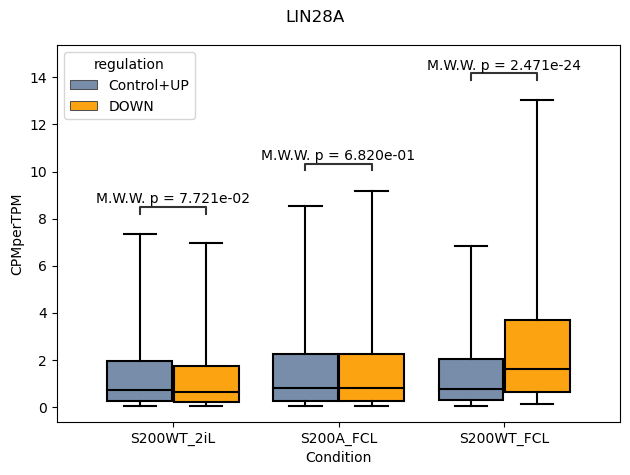

PABPC1
S200WT_2iL_Control+UP vs. S200WT_2iL_DOWN: Mann-Whitney-Wilcoxon test two-sided, P_val:8.776e-01 U_stat=6.252e+05
KO_2iL_Control+UP vs. KO_2iL_DOWN: Mann-Whitney-Wilcoxon test two-sided, P_val:4.735e-01 U_stat=6.106e+05
KO_FCL_Control+UP vs. KO_FCL_DOWN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.710e-01 U_stat=6.042e+05
S200WT_FCL_Control+UP vs. S200WT_FCL_DOWN: Mann-Whitney-Wilcoxon test two-sided, P_val:6.238e-36 U_stat=4.127e+05


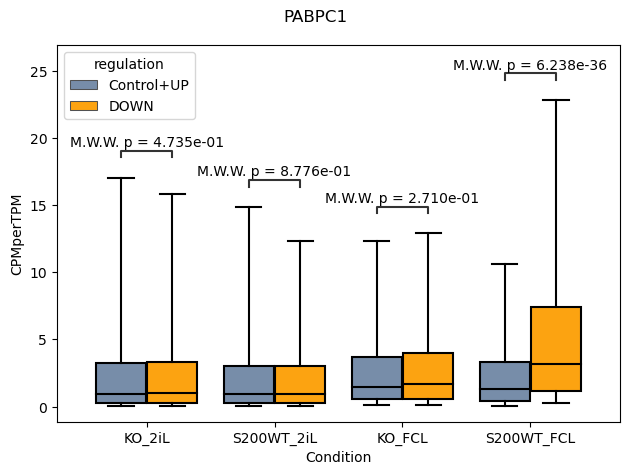

PABPC4
S200WT_FCL_Control+UP vs. S200WT_FCL_DOWN: Mann-Whitney-Wilcoxon test two-sided, P_val:8.754e-39 U_stat=4.041e+05
KO_FCL_Control+UP vs. KO_FCL_DOWN: Mann-Whitney-Wilcoxon test two-sided, P_val:7.839e-01 U_stat=6.180e+05


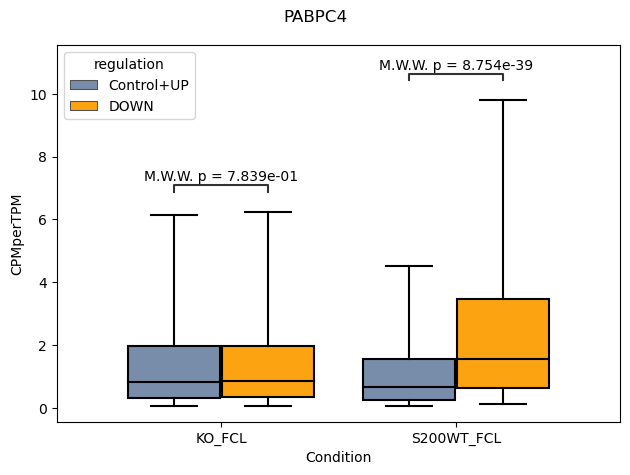

In [78]:
for prot, df in DfQuantMelt.groupby('Protein'):
    print(prot)
    # Set boxplot kwargs for seaborn, set edgecolor to black
    PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
    # Make white boxplots of uniform color with black edges
    df['regulation'] = df.name.map({'DOWN': 'DOWN', 'CONTROL': 'Control+UP', 'UP':'Control+UP'})
    g = sns.boxplot(
        data=df, hue='regulation', y='CPMperTPM', x='Condition', showfliers=False, hue_order=['Control+UP', 'DOWN'], palette=['#778da9', '#fca311'],
        order=order_dict[prot], **PROPS, saturation=1, whis=[5, 95]
        )
    # Save source data
    df.to_csv(f'{srcOut}{prot}_CPMperTPM_300ntUpstreamOf3PTermini_minRegLen301nt.csv', index=False)

    #Add significance
    pairs = []
    for i in order_dict[prot]:
        pairs.append(((i, 'DOWN'), (i, 'Control+UP')))

    # subset the table otherwise the stats were calculated on the whole dataset
    annot = Annotator(
        g, pairs, data=df, hue='regulation', y='CPMperTPM', x='Condition', hue_order=['Control+UP', 'DOWN'], order=order_dict[prot]
        )
    annot.configure(test='Mann-Whitney', text_format='full', loc='inside')
    _, corrected_results = annot.apply_and_annotate()
    g.figure.suptitle(prot)
    plt.tight_layout()
    plt.show()
    g.figure.savefig(f'{outpath}{prot}_CPMperTPM_300ntUpstreamOf3PTermini_minRegLen301nt_singlePlot.pdf', bbox_inches='tight')

LIN28A
[('S200WT_2iL', 'S200A_FCL'), ('S200WT_2iL', 'S200WT_FCL')]
S200WT_2iL vs. S200A_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:2.320e-01 U_stat=2.210e+06
S200WT_2iL vs. S200WT_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.529e-01 U_stat=2.201e+06
[('S200WT_2iL', 'S200A_FCL'), ('S200WT_2iL', 'S200WT_FCL')]
S200WT_2iL vs. S200A_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:2.070e-02 U_stat=1.583e+05
S200WT_2iL vs. S200WT_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:2.605e-23 U_stat=1.141e+05


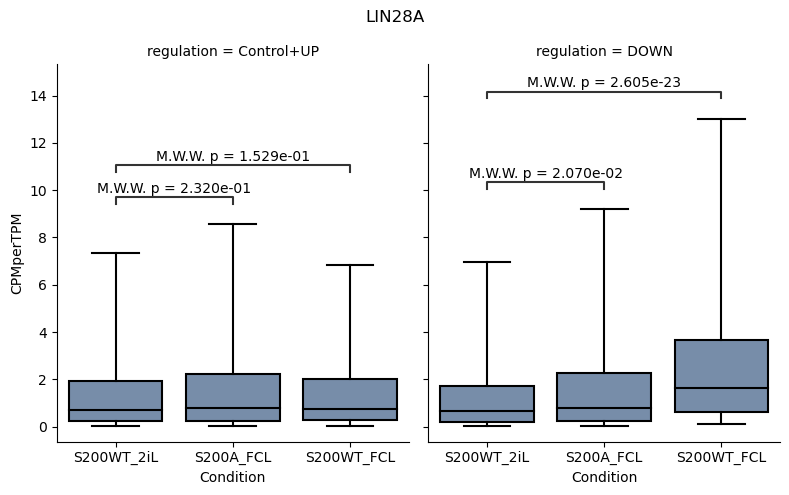

PABPC1
[('KO_2iL', 'S200WT_2iL'), ('KO_2iL', 'KO_FCL'), ('KO_2iL', 'S200WT_FCL')]
KO_2iL vs. S200WT_2iL: Mann-Whitney-Wilcoxon test two-sided, P_val:9.759e-01 U_stat=2.259e+06
KO_FCL vs. S200WT_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.073e-03 U_stat=2.389e+06
KO_2iL vs. KO_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:9.877e-16 U_stat=1.937e+06
KO_2iL vs. S200WT_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:3.930e-07 U_stat=2.055e+06
[('KO_2iL', 'S200WT_2iL'), ('KO_2iL', 'KO_FCL'), ('KO_2iL', 'S200WT_FCL')]
KO_2iL vs. S200WT_2iL: Mann-Whitney-Wilcoxon test two-sided, P_val:4.643e-01 U_stat=1.759e+05
KO_FCL vs. S200WT_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:8.770e-15 U_stat=1.268e+05
KO_2iL vs. KO_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.553e-05 U_stat=1.467e+05
KO_2iL vs. S200WT_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:6.301e-27 U_stat=1.094e+05


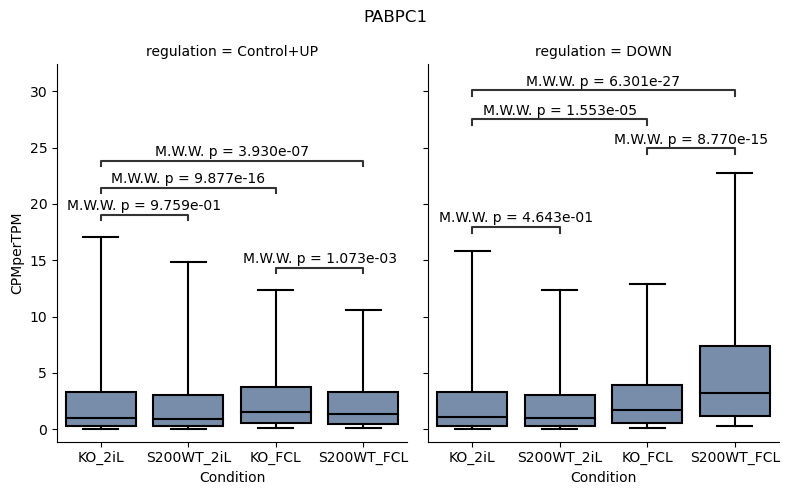

PABPC4
[('KO_FCL', 'S200WT_FCL')]
KO_FCL vs. S200WT_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:2.151e-09 U_stat=2.497e+06
[('KO_FCL', 'S200WT_FCL')]
KO_FCL vs. S200WT_FCL: Mann-Whitney-Wilcoxon test two-sided, P_val:5.515e-14 U_stat=1.281e+05


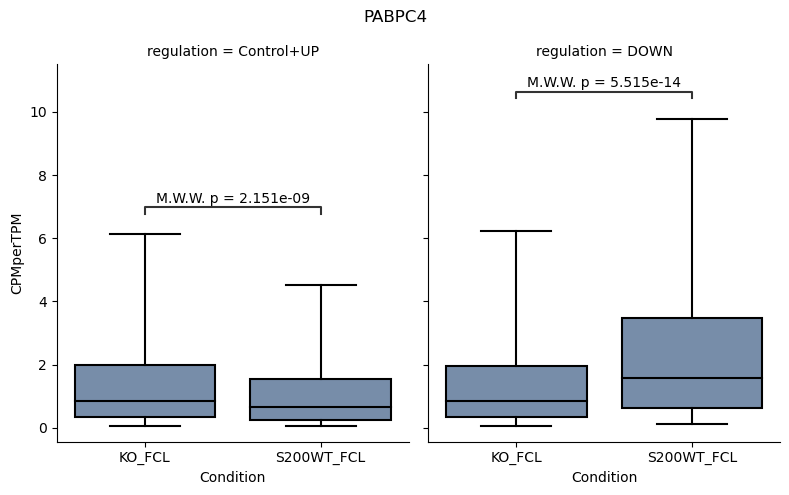

In [ ]:
for prot, df in DfQuantMelt.groupby('Protein'):
    print(prot)
    # Set boxplot kwargs for seaborn, set edgecolor to black
    PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
    # Make white boxplots of uniform color with black edges
    df['regulation'] = df.name.map({'DOWN': 'DOWN', 'CONTROL': 'Control+UP', 'UP':'Control+UP'})
    g = sns.catplot(
        kind='box', data=df, col='regulation', y='CPMperTPM', x='Condition', showfliers=False, col_order=['Control+UP', 'DOWN'],
        order=order_dict[prot], **PROPS, saturation=1, whis=[5, 95], aspect=.8, color='#778da9'
        )
    # #Add significance
    for idx, ax in g.axes_dict.items():

        pairs = []
        for i in range(1, len(order_dict[prot])):
            pairs.append((order_dict[prot][0], order_dict[prot][i]))
        print(pairs)
        if prot == 'PABPC1':
            pairs.append(('KO_FCL', 'S200WT_FCL'))

        # subset the table otherwise the stats were calculated on the whole dataset
        annot = Annotator(
            ax, pairs, data=df.loc[df.regulation == idx],  y='CPMperTPM', x='Condition', order=order_dict[prot]
            )
        annot.configure(test='Mann-Whitney', text_format='full', loc='inside')
        _, corrected_results = annot.apply_and_annotate()
    g.figure.suptitle(prot)
    plt.tight_layout()
    plt.show()
    g.figure.savefig(f'{outpath}{prot}_CPMperTPM_300ntUpstreamOf3PTermini_minRegLen301nt_additiveeffect.pdf', bbox_inches='tight')